## I-2 Hypothesis Testing

Suppose that, for privacy reasons, the company has to change its policy and make the indicator of <br />whether each bike ride corresponds to a casual (customer) or non-casual (subscriber)
user confidential.<br /><br /> In the future the company will no longer have access to this feature. However, this feature is particularly<br /> useful, because depending on the type of user the company
might want to give them different promotions<br /> and advertisement. Therefore, in this part we
will design a test for whether the user is casual or not. We will<br /> also try to prevent too many
false discoveries, i.e. falsely declaring a casual user as a non-casual one.

**Labeling:** This section will generate models for Chicago's data.<br />
* Let n denote the total number of samples. For each i $\in \{1,....,n\}$, denote by $Y_{i}$ the indicator whether the user is casual ($Y_{i} = 0$) or non-casual ($Y_{i} = 1$). <br /> 
* For i $\in \{1,....,n\}$, let $X_{i}$ denote the feature vector consisting of the following 3 features: trip duration, ride start time and ride stop time. As the start and stop time, simply take the hour of the corresponding time. For example, if the ride starts at 13:05, take 13 as the start time. Similar for stop time.

**Train_Test_Split:** Split the data set into three uniformly-without-replacement randomly sampled subsets:
S1 (60% of the whole data set), S2 (20% of the whole data set) and S3 (20% of the whole
data set). Recall that we need the model of the data under the null in order to compute
p-values. We will use S1 and S2 to learn this model, and then compute p-values on S3.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import sklearn 
import math
import statistics as stat
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
## load the data, choose data in Chicago for this part of the question
chi_df = pd.read_csv("../data/bikeshare/chicago.csv")

In [11]:
### Contruct the feature matrix 
chi_df['starttime_pd'] = pd.to_datetime(chi_df['starttime'])
chi_df['starthour'] = chi_df['starttime_pd'].dt.hour
chi_df['stoptime_pd'] = pd.to_datetime(chi_df['stoptime'])
chi_df['endhour'] = chi_df['stoptime_pd'].dt.hour
feature_matrix = chi_df[["starthour", "endhour","tripduration","usertype"]]
feature_matrix["tripduration"] = feature_matrix["tripduration"].div(60).round(4)
feature_matrix.head()

<ipython-input-11-b3bc8766854f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_matrix["tripduration"] = feature_matrix["tripduration"].div(60).round(4)


,starthour,endhour,tripduration,usertype
0,23,23,15.4333,Subscriber
1,22,23,3.3000,Subscriber
2,22,22,2.0667,Subscriber
3,22,22,19.6833,Subscriber
4,22,22,10.9333,Subscriber


### Split the data and briefly display a summary 

In [17]:
### Split the data
S1, S2, S3 = np.split(feature_matrix.sample(frac=1), [int(.6*len(feature_matrix)), int(.8*len(feature_matrix))])
data = [['S1', S1.shape[0],S1.shape[1]], ['S2', S2.shape[0], S2.shape[1]], ['S3', S3.shape[0],S3.shape[1]]]
df = pd.DataFrame(data, columns = ['DataSet', '# of Observation', '# of variables']) 
df

,DataSet,# of Observation,# of variables
0,S1,43278,4
1,S2,14426,4
2,S3,14427,4


### 2.1 Logistic Regression

${Pr}(Y_{i} = 1 | X_{i}) = \frac{1}{1 + e^{-\theta^{T}X_{i} } }$

for some $\theta= (\theta_{1}, \theta_{2}, \theta_{3})$. Use S1 to train a logistic regression model for predicting $Y_{i}$<br />
from $X_{i}$ according to the above model. Denote by $\theta_{*}$ the learned value of $\theta$. 

**Apply the logistic regression on S1 with sklearn package, and we get the $\theta$ estimates as followe**

In [13]:
from sklearn.linear_model import LogisticRegression

In [18]:
S1_x = S1[["starthour", "endhour","tripduration"]]
S1_y = S1["usertype"]
S2_x = S2[["starthour", "endhour","tripduration"]]
S2_y = S2["usertype"]
S3_x = S3[["starthour", "endhour","tripduration"]]
S3_y = S3["usertype"]

In [19]:
# fit the model
logisticRegr = LogisticRegression()
logisticRegr.fit(S1_x, S1_y)

LogisticRegression()

In [20]:
## Get theta estimates
theta_star = logisticRegr.coef_
theta_star

array([[-0.01514543, -0.02127695, -0.08645444]])

#### Fitted $\theta$ displayed

In [30]:
data = [['$\theta_{* starthour}$', theta_star[0][0]], ['$\theta_{* endhour}$', theta_star[0][1]], ['$\theta_{* tripDuration}$', theta_star[0][2]]]
df = pd.DataFrame(data, columns = ['theta_star', 'value']) 
df

,theta_star,value
0,$\theta_{* starthour}$,-0.015145
1,$\theta_{* endhour}$,-0.021277
2,$\theta_{* tripDuration}$,-0.086454


### 2.2 P-values Calculations under two methods
* For each sample $(X_{i},Y_{i})$ in $S_{2}$, compute $s_{i}^{(2)} = \frac{1}{1 + e^{-\theta_{*}^{T}X_{i} } }$
* For each sample $(X_{j},Y_{j})$ in $S_{3}$, compute a p-value as $P_{j} = \frac{1}{|{S_{2,0}}|} \{i \in S_{2,0}: s_{i}^{(2)} > s_{j}^{(3)} \}$  , 
<br /> where $S_{2,0}$ is the subset of $S_{2}$ that consists of casual users
($Y_{i} = 0$), 
<br /> as usual we use $|\cdot|$ to denote the cardinality of a set,
<br />usage will be explained after.

In [41]:
## Compute the si2
si_2 = logisticRegr.predict_proba(S2_x)[:, 1]

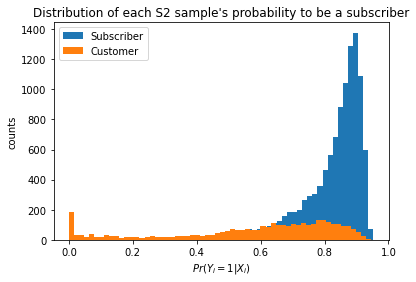

In [61]:
## plot p-values of S2
S2["prob"] = si_2
plt.hist(S2[S2["usertype"] == "Subscriber"]['prob'], bins = 60)
plt.hist(S2[S2["usertype"] == "Customer"]['prob'], bins = 60)
plt.ylabel("counts")
plt.xlabel("${Pr}(Y_{i} = 1 | X_{i}$)")
plt.legend(["Subscriber", "Customer"])
plt.title("Distribution of each S2 sample's probability to be a subscriber")
plt.show()

**Interpretation:** This is a traditional logistic regression, and we see the counts of both customer and subscriber peak up when ${Pr}(Y_{i} = 1 | X_{i})$ gets larger, that leads to a higher false positive rate. To fix this issue, we apply some correction algorithms like what we did for S3

In [43]:
## Compute si3 
si_3 = logisticRegr.predict_proba(S3_x)[:, 1]
### get the S_2,0 group
print(si_2.shape, S2.shape)
si_20 = si_2[S2["usertype"] == "Customer"]
print("number of elements in S_2,0:", len(si_20))

(14426,) (14426, 5)
number of elements in S_2,0: 3415


In [44]:
## calculate the p-values of S3 by the criteria described above
P_s3 = []
for i in range(len(S3)):
    P_s3.append(np.sum(si_20 > si_3[i]) / si_20.shape[0])
S3["p-value"] = P_s3  
S3.head()

,starthour,endhour,tripduration,usertype,p-value
1833,6,7,22.4333,Subscriber,0.371596
21841,8,8,7.4167,Subscriber,0.023133
18758,17,17,20.4167,Subscriber,0.449195
54189,10,11,21.5167,Customer,0.395900
9013,14,14,14.6167,Subscriber,0.215227


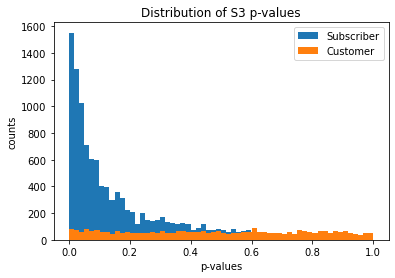

In [45]:
## plot p-values of S3
plt.hist(S3[S3["usertype"] == "Subscriber"]['p-value'], bins = 60)
plt.hist(S3[S3["usertype"] == "Customer"]['p-value'], bins = 60)
plt.ylabel("counts")
plt.xlabel("p-values")
plt.legend(["Subscriber", "Customer"])
plt.title("Distribution of S3 p-values")
plt.show()

**Interpretation:** the p-values of subscribers and casual customers are distributbed differently under the "S3" algorithm.

The p-values of subscribers are distributed heavily right tail, with most p-values lying range between 0.0 and 0.2. That's a<br /> good sign as the we do want subscribers have small p-values, so that we have sufficient evidence to "reject Null" and <br />classify them as Subscribers(correct labeling).

By contrast, the p-values of casual customers are distributed uniformly, and does not peak up when p-values gets closer to<br /> 0, and that reduces the false positive rate to some extent.

Therefore, with a small p-value, we have more confidence to predict a rider as a subscriber comparing to S2. I will explore<br /> how much better it is in 2.3

### 2.3 Benjamini-Hochberg

With $|S_{3}|$ p-values, run the Benjamini-Hochberg algorithm under level
0.2 on these p-values, and compute the false discovery proportion (FDP) and sensitivity.
Repeat the whole procedure from above for 200 different randomly sampled $S_{1}$, $S_{2}$ and
$S_{3}$. Then we would have 200 sets of $S_{3}$
p-values, and get 200 different false discovery proportions and sensitivities. Report the
average FDP and sensitivity over these 200 trials. Is the average FDP above or below
0:2? Can you explain why it is or isn't?

In [49]:
def benjamini_hochberg(p_values, alpha):
    # returns decisions: a binary vector of the same length as p-values, 
    # where decisions[i] is 1 if p_values[i] is deemed significant at level alpha, and 0 otherwize
    
    n = len(p_values)
    p_sorted = np.sort(p_values)

    decisions = np.zeros(len(p_values))

    for j in range(len(p_values)):
        if p_sorted[j] <= (j+1)*alpha/n:
            largest_k = j
        
    for t in range(len(p_values)):
        if p_values[t] <= p_sorted[largest_k]:
            decisions[t] = True
        else:
            decisions[t] = False    

    return decisions

In [50]:
decisions = benjamini_hochberg(P_s3, 0.2)
S3["decisions"] = decisions

In [60]:
### Get FDR & sensitivity
FDR = sum((S3["usertype"] == "Customer") & (S3["decisions"] == 1))/len(S3)
Sen = sum((S3["usertype"] == "Subscriber") & (S3["decisions"] == 1))/len(S3)
print("FDR         : ", FDR)
print("Sensitivity : ", Sen)

FDR         :  0.020378457059679767
Sensitivity :  0.3204408400914951


In [53]:
## Repeat for 200 times and find the average
def FDR_Sen(df): 
    ### Split the data
    #feature_matrix = df.sample(frac=1).reset_index(drop=True)
    S1, S2, S3 = np.split(feature_matrix.sample(frac=1), [int(.6*len(feature_matrix)), int(.8*len(feature_matrix))])
        
    ### data split
    S1_x = S1[["starthour", "endhour","tripduration"]]
    S1_y = S1["usertype"]
    S2_x = S2[["starthour", "endhour","tripduration"]]
    S2_y = S2["usertype"]
    S3_x = S3[["starthour", "endhour","tripduration"]]
    S3_y = S3["usertype"]
    
    ## logistic fit
    logisticRegr = LogisticRegression()
    logisticRegr.fit(S1_x, S1_y)
    
    si_2 = logisticRegr.predict_proba(S2_x)[:, 1]
    si_3 = logisticRegr.predict_proba(S3_x)[:, 1]
    
    si_20 = si_2[S2["usertype"] == "Customer"]
    
    P_s3 = []
    for i in range(len(S3)):
        P_s3.append(np.sum(si_20 > si_3[i]) / si_20.shape[0])
        
    S3["p-value"] = P_s3
    decisions = benjamini_hochberg(P_s3, 0.2)
    S3["decisions"] = decisions
    
    FDR = sum((S3["usertype"] == "Customer") & (S3["decisions"] == 1) == True)/len(S3)
    Sen = sum((S3["usertype"] == "Subscriber") & (S3["decisions"] == 1) == True)/len(S3)

    return FDR, Sen

In [54]:
FDRs = []
SENs = []
for i in range(200):
    values = FDR_Sen(feature_matrix)
    FDRs.append(values[0])
    SENs.append(values[1])

In [59]:
print("FDP(Average false discovery rate) : ", stat.mean(FDRs))
print("Average Sensitivity               : ", stat.mean(SENs))

FDP(Average false discovery rate) :  0.013377001455604077
Average Sensitivity               :  0.260093921120122


#### In traditional decision method 
Let's also compute the FDP and average sensitivity using regular traditional decision method for $S_{2}$: <br />(decision = 1 if $s_{i}^{(2)} > 0.5$; decision = 0 if $s_{i}^{(2)} \leq 0.5$)

In [63]:
S2["decisions"] = np.where(S2['prob'] > 0.5, True, False)

In [65]:
### Get FDR & sensitivity
FDR = sum((S2["usertype"] == "Customer") & (S2["decisions"] == 1))/len(S2)
Sen = sum((S2["usertype"] == "Subscriber") & (S2["decisions"] == 1))/len(S2)
print("FDR         : ", FDR)
print("Sensitivity : ", Sen)

FDR         :  0.1687924580618328
Sensitivity :  0.7451129904339387


**Interpretation:** Benjamini_Hochberg successfully decrease the false discovery rate, but meanwhile diminish the sensitivity, in the next part. We'll explore how to improve average sensitivity as well as maintaing the low FDP.